### 作業
理解範例後請嘗試將關鍵點畫在圖像上，確保圖像及資料有正確讀取。
Hint: 可以用 [matplotlib 的 scatter](https://matplotlib.org/3.1.1/gallery/shapes_and_collections/scatter.html) 或者 [opencv 的 cv2.circle](https://docs.opencv.org/master/dc/da5/tutorial_py_drawing_functions.html)

### 範例
接下來的程式碼會示範如何讀取 kaggle facial keypoint detection 資料集

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# 使用 colab 環境的同學請執行以下程式碼
# %tensorflow_version 1.x # 確保 colob 中使用的 tensorflow 是 1.x 版本而不是 tensorflow 2
# import tensorflow as tf
# print(tf.__version__)

# import os
# from google.colab import drive 
# drive.mount('/content/gdrive') # 將 google drive 掛載在 colob，
# %cd 'gdrive/My Drive'
# os.system("mkdir cupoy_cv_part4") # 可以自己改路徑
# %cd cupoy_cv_part4 # 可以自己改路徑

In [ ]:
# 如果要使用 kaggle API 下載資料的話，請用以下程式碼
# os.environ['KAGGLE_USERNAME'] = '____' # 請按照 Day42 簡報內容，獲取 kaggle api 需要用到的 username
# os.environ['KAGGLE_KEY'] = '____' # 請按照 Day42 簡報獲取 kaggle api 需要用到的 key
# !kaggle competitions download -c facial-keypoints-detection
# !unzip test.zip
# !unzip training.zip

### 資料前處理
資料分為兩部分，一個是關鍵點坐標，總共 15 個關鍵點，所以坐標相關的值有 15 x 2 = 30 維；
另外還有 96 x 96 的灰階像素值。

讀取資料後，先簡單地過濾有缺失某些關鍵點坐標的資料，然後再把資料 scale 到 [-0.5, 0.5] 的範圍

In [3]:
# 讀取 csv 文件
data = pd.read_csv("C:/AI_Learning/1st-DL-CVMarathon_Rico/1st-DL-CVMarathon_Rico/電腦視覺深度學習基礎/人臉關鍵點/training.csv")

In [6]:
# 前 5 筆資料, .T 的作用是轉置，如果不理解可以和 data.head() 的結果相比較
data.head(10).T

,0,1,2,3,4,5,6,7,8,9
left_eye_center_x,66.0336,64.3329,65.0571,65.2257,66.7253,69.6807,64.1319,67.4689,65.8029,64.1212
left_eye_center_y,39.0023,34.9701,34.9096,37.2618,39.6213,39.9687,34.29,39.4135,34.7552,36.7403
right_eye_center_x,30.227,29.9493,30.9038,32.0231,32.2448,29.1836,29.579,29.356,27.4758,29.4689
right_eye_center_y,36.4217,33.4487,34.9096,37.2618,38.042,37.5634,33.138,39.6217,36.1856,38.3902
left_eye_inner_corner_x,59.5821,58.8562,59.412,60.0033,58.5659,62.8643,57.7972,59.555,58.6522,58.6209
left_eye_inner_corner_y,39.6474,35.2743,36.321,39.1272,39.6213,40.1693,35.154,40.4548,37.3293,37.8406
left_eye_outer_corner_x,73.1303,70.7227,70.9844,72.3147,72.5159,76.8982,69.0266,75.5916,72.953,71.272
left_eye_outer_corner_y,39.97,36.1872,36.321,38.381,39.8845,41.1719,34.29,40.0382,35.8995,37.2903
right_eye_inner_corner_x,36.3566,36.0347,37.6781,37.6186,36.9824,36.401,34.7617,37.4782,36.3424,36.3446
right_eye_inner_corner_y,37.3894,34.3615,36.321,38.7541,39.0949,39.3676,33.714,40.4548,37.0432,39.4905


In [8]:
data['Image'][0][:100]

'238 236 237 238 240 240 239 241 241 243 240 239 231 212 190 173 148 122 104 92 79 73 74 73 73 74 81 '

用 pandas 讀取 csv 文件後可以發現前 30 個 column 是坐標值，最後一個 column 是圖片像素值的字串 (以空白鍵區隔)，接下來我們就以下的函數來做資料的讀取以及前處理，請盡量仔細理解這個函數

In [9]:
# 過濾有缺失值的 row
data = data.dropna()

# 將圖片像素值讀取為 numpy array 的形態
data['Image'] = data['Image'].apply(lambda img: np.fromstring(img, sep=' ')).values 

# 單獨把圖像 array 抽取出來
imgs = np.vstack(data['Image'].values)/255
# reshape 為 96 x 96
imgs = imgs.reshape(data.shape[0], 96, 96)
# 轉換為 float
imgs = imgs.astype(np.float32)

# 提取坐標的部分
points = data[data.columns[:-1]].values

# 轉換為 float
points = points.astype(np.float32)

# normalize 坐標值到 [-0.5, 0.5]
points = points/96 - 0.5

In [10]:
print("圖像資料shape:", imgs.shape, "\n關鍵點資料shape:", points.shape)

圖像資料shape: (2140, 96, 96) 
關鍵點資料shape: (2140, 30)


In [31]:
sample_img = imgs[0]
print(sample_img)
points = data[data.columns[:-1]].values
sample_points = points[0]
sample_points_x = [point for i, point in enumerate(sample_points) if i%2 == 0]
sample_points_y = [point for i, point in enumerate(sample_points) if i%2 != 0]
print(sample_points_x)

[[0.93333334 0.9254902  0.92941177 ... 0.98039216 0.98039216 0.98039216]
 [0.92156863 0.93333334 0.9254902  ... 0.9764706  0.98039216 0.9843137 ]
 [0.92941177 0.9254902  0.92941177 ... 0.9843137  0.9843137  0.98039216]
 ...
 [0.7294118  0.7176471  0.70980394 ... 0.20392157 0.22352941 0.23529412]
 [0.7411765  0.7372549  0.8117647  ... 0.23921569 0.27058825 0.30588236]
 [0.7490196  0.72156864 0.72156864 ... 0.27450982 0.29411766 0.3529412 ]]
[66.0335639098, 30.2270075188, 59.582075188000005, 73.1303458647, 36.3565714286, 23.4528721805, 56.9532631579, 80.2271278195, 40.2276090226, 16.3563789474, 44.4205714286, 61.1953082707, 28.6144962406, 43.3126015038, 43.1307067669]


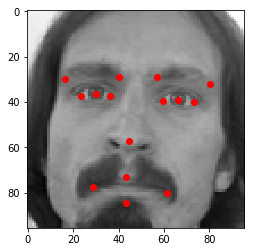

In [32]:
plt.imshow(sample_img, cmap='gray')
plt.scatter(sample_points_x, sample_points_y, c='r')
plt.show()